In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [5]:
!pip install segment-anything

In [6]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import os
import glob
import sys
sys.path.append('../src')
from metrics import dice_coefficient
from utils import crop_im

In [7]:
# Define data path
DATA_DIR = '../data'

# Get the paths
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [8]:
def get_dice_scores(sub_dir):

    dice_scores = []

    for path in test_paths:
        # read in ground truth
        seg_path = os.path.join(DATA_DIR, 'ground-truth', path + '.npy')
        mask = np.load(seg_path)

        # Get menisc masks from this
        mask = mask[...,-1]

        gt = crop_im(mask)

        # Get prediction
        pred_path = os.path.join(DATA_DIR, sub_dir, path + '.npy')
        pred = np.load(pred_path)

        # Get dice coeff
        dice = dice_coefficient(torch.tensor(pred), torch.tensor(gt))
        dice_scores.append(dice)
        print(dice)

    return dice_scores

In [ ]:
unet_dice = get_dice_scores('unet_test_preds')

0.9165757298469543
0.9171538352966309
0.8538557887077332
0.8671984672546387
0.8750834465026855
0.8555957674980164
0.8965312242507935
0.9074695110321045
0.8172127604484558
0.8460511565208435
0.8586600422859192
0.819229245185852
0.8789969086647034
0.8601400852203369
0.8387756943702698
0.8277266621589661
0.8693159222602844
0.8700119256973267
0.9051049947738647
0.8704000115394592
0.8908730745315552
0.876746416091919
0.8802722096443176
0.8638269305229187
0.8681048154830933
0.8711496591567993
0.8842816352844238
0.8780021071434021


In [ ]:
np.save('unet_dice.npy', unet_dice)

In [ ]:
np.array(unet_dice).mean()

0.8701552152633667

In [9]:
# Get dice scores for all saved test mask predictions
#unet_dice = np.load('unet_dice.npy')
frozen_enc_dice = np.load('frozen_enc_dice.npy')
sam_end2end_dice = np.load('end2end_dice.npy')
unet_dice = np.load('unet_dice.npy')

In [10]:
frozen_enc_dice

array([0.79556369, 0.78541402, 0.75424335, 0.7047078 , 0.75594702,
       0.75159416, 0.76094424, 0.77768476, 0.74021966, 0.76388161,
       0.77412167, 0.73116374, 0.73826995, 0.68702917, 0.71895052,
       0.75333971, 0.72972921, 0.74777326, 0.79767881, 0.76805007,
       0.71885332, 0.73177781, 0.76830711, 0.7860763 , 0.6687333 ,
       0.75264309, 0.79336828, 0.79558774])

In [11]:
# Make dataframe of these?
dice_dict = {
    "SAM 1": frozen_enc_dice,
    "SAM 2": sam_end2end_dice,
    "U-Net": unet_dice
}
dice_df = pd.DataFrame(dice_dict)

In [12]:
dice_df

,SAM 1,SAM 2,U-Net
0,0.795564,0.908744,0.916576
1,0.785414,0.896815,0.917154
2,0.754243,0.866129,0.853856
3,0.704708,0.826021,0.867198
4,0.755947,0.857238,0.875083
5,0.751594,0.866864,0.855596
6,0.760944,0.899006,0.896531
7,0.777685,0.913175,0.907470
8,0.740220,0.778109,0.817213
9,0.763882,0.816793,0.846051


In [13]:
# get average, standard dev.
dice_df.describe()

,SAM 1,SAM 2,U-Net
count,28.000000,28.000000,28.000000
mean,0.751845,0.858769,0.870155
std,0.032805,0.033636,0.025919
min,0.668733,0.778109,0.817213
25%,0.731624,0.835306,0.857894
50%,0.753792,0.866497,0.870206
75%,0.775012,0.880885,0.881275
max,0.797679,0.913175,0.917154


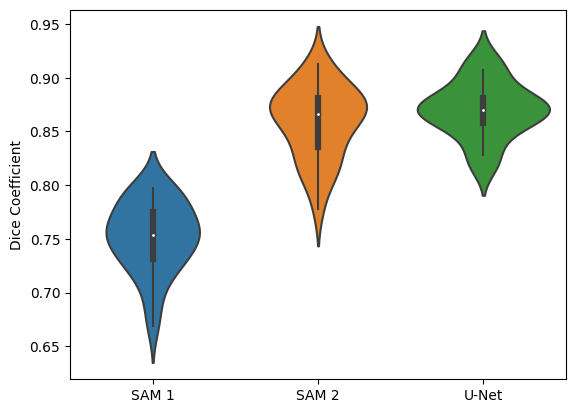

In [14]:
# Try violin plot
import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
ax = sns.violinplot(data=dice_df)
plt.ylabel("Dice Coefficient")
plt.savefig("dice_violin", bbox_inches="tight", dpi=500)
plt.show()

In [16]:
# What are the lowest Dice scores across SAM 2 and U-Net?
# Rank dice scores of SAM 2 and UNet
ranked_SAM2 = dice_df['SAM 2'].rank(ascending=False, method='min').astype(int).values - 1
ranked_UNet = dice_df['U-Net'].rank(ascending=False, method='min').astype(int).values - 1

# Calculate the average rank for each row
average_rank = (ranked_SAM2 + ranked_UNet) / 2

# Add the 'Average Rank' column to the DataFrame
dice_df['Average Rank'] = average_rank

print(dice_df)

       SAM 1     SAM 2     U-Net  Average Rank
0   0.795564  0.908744  0.916576           1.0
1   0.785414  0.896815  0.917154           1.5
2   0.754243  0.866129  0.853856          18.0
3   0.704708  0.826021  0.867198          19.5
4   0.755947  0.857238  0.875083          13.5
5   0.751594  0.866864  0.855596          17.0
6   0.760944  0.899006  0.896531           3.0
7   0.777685  0.913175  0.907470           1.0
8   0.740220  0.778109  0.817213          27.0
9   0.763882  0.816793  0.846051          23.5
10  0.774122  0.849600  0.858660          19.0
11  0.731164  0.818379  0.819229          24.5
12  0.738270  0.864455  0.878997          11.5
13  0.687029  0.804591  0.860140          22.5
14  0.718951  0.805168  0.838776          24.5
15  0.753340  0.836758  0.827727          22.5
16  0.729729  0.854550  0.869316          16.0
17  0.747773  0.847469  0.870012          16.5
18  0.797679  0.879230  0.905105           5.5
19  0.768050  0.871368  0.870400          12.5
20  0.718853 

In [17]:
ranked_SAM2

array([ 1,  3, 14, 22, 16, 13,  2,  0, 27, 24, 18, 23, 15, 26, 25, 20, 17,
       19,  8, 12, 11,  6, 10,  5, 21,  9,  7,  4])

In [18]:
ranked_UNet

array([ 1,  0, 22, 17, 11, 21,  4,  2, 27, 23, 20, 26,  8, 19, 24, 25, 15,
       14,  3, 13,  5, 10,  7, 18, 16, 12,  6,  9])

In [19]:
highest_rank = dice_df['Average Rank'].idxmax()

In [20]:
highest_rank

8

In [21]:
ranked_SAM2[highest_rank]

27

In [22]:
ranked_UNet[highest_rank]

27

In [23]:
test_paths[highest_rank]

'test_005_V00'